# Import

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.4f' % x)

PROJECT_DIR = os.path.join(os.path.dirname('bert_modeling.ipynb'), os.pardir) + '/..'

In [2]:
# Google Colab setup
from google.colab import drive, userdata
drive.mount('/content/drive/')
PROJECT_DIR = userdata.get('PROJECT_DIR')

Mounted at /content/drive/


In [3]:
# Reading the up-sampled dataset
up_train = pd.read_csv(f'{PROJECT_DIR}/data/processed/augmented_train.csv', usecols=['Description', 'Accident Level'])
test = pd.read_csv(f'{PROJECT_DIR}/data/processed/augmented_test.csv', usecols=['Description', 'Accident Level'])
up_train.head()

,Description,Accident Level
0,By manually moving a steel cabinet for disposa...,3
1,Once the mooring of the faneles in the detonat...,1
2,When performing cleaning activity of the area ...,3
3,The technician was doing the magnetometric sur...,1
4,The operator cleaned with spatula spear throug...,1


In [4]:
# Splitting features and targets
x_train = up_train['Description'].str.strip()
y_train = up_train['Accident Level']

x_test = test['Description'].str.strip()
y_test = test['Accident Level']

In [5]:
# Label encoding to ensure the labels start from 0
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [6]:
# One-hot encoding
from tensorflow.keras.utils import to_categorical

y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

In [7]:
# Tensor slicing
from tensorflow.data import Dataset

train_ds = Dataset.from_tensor_slices((x_train, y_train_ohe))
test_ds = Dataset.from_tensor_slices((x_test, y_test_ohe))

# BERT

## Installations

In [8]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.15.*"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 63.5 MB/s eta 0:00:00


In [9]:
# To define AdamW Optimizer
!pip install "tf-models-official==2.15.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.7 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=08748636bfcfd2793344755779c6554a7ad3f386b3b1f5814cbc342a02bd203a
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [10]:
from tensorflow import string
import tensorflow_text as text
from tensorflow_hub import KerasLayer
from tensorflow.keras import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.layers import Input, Dropout, Dense, Bidirectional, LSTM, Embedding, GlobalMaxPooling1D

In [11]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

def build_bert_lstm():
    text_input = Input(shape=(), dtype=string, name='text_input')
    bert_preprocessing = KerasLayer(tfhub_handle_preprocess, name='bert_preprocessing')(text_input)
    bert_encoder = KerasLayer(tfhub_handle_encoder, trainable=False, name='bert_encoder')(bert_preprocessing)

    lstm_1 = Bidirectional(LSTM(128, return_sequences=True))(bert_encoder['sequence_output'])
    lstm_2 = Bidirectional(LSTM(64, return_sequences=True))(lstm_1)
    max_pool = GlobalMaxPooling1D()(lstm_2)

    dropout_1 = Dropout(0.2)(max_pool)
    dense_1 = Dense(64, activation='relu')(dropout_1)

    dropout_2 = Dropout(0.2)(dense_1)
    dense_2 = Dense(32, activation='relu')(dropout_2)

    dropout_3 = Dropout(0.2)(dense_2)
    classifier = Dense(5, activation='softmax', name='classifier')(dropout_3)

    model = Model(text_input, classifier)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=AdamW(learning_rate=3e-5, weight_decay=0.001, epsilon=1e-07),
        metrics=['accuracy', Recall(), Precision()]
    )

    return model

In [12]:
bert_lstm = build_bert_lstm()
bert_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None,)]                    0         []                            
                                                                                                  
 bert_preprocessing (KerasL  {'input_word_ids': (None,    0         ['text_input[0][0]']          
 ayer)                       128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

callbacks = [
    EarlyStopping(monitor='loss', patience=10, min_delta=1e-2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_delta=1e-6, verbose=1)
]

In [14]:
history = bert_lstm.fit(train_ds.batch(32), validation_data=test_ds.batch(32), epochs=100, callbacks=callbacks)

Epoch 1/100
37/37 [==============================] - 37s 444ms/step - loss: 1.6850 - accuracy: 0.1784 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.5961 - val_accuracy: 0.0857 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 3.0000e-05
Epoch 2/100
37/37 [==============================] - 14s 378ms/step - loss: 1.6192 - accuracy: 0.2130 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.5802 - val_accuracy: 0.1333 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 3.0000e-05
Epoch 3/100
37/37 [==============================] - 14s 385ms/step - loss: 1.6029 - accuracy: 0.2424 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.5645 - val_accuracy: 0.2190 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 3.0000e-05
Epoch 4/100
37/37 [==============================] - 16s 435ms/step - loss: 1.5948 - accuracy: 0.2277 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.5500 - val_accuracy: 0.3238 - val_recall: 0.0000e+00 - val_pre

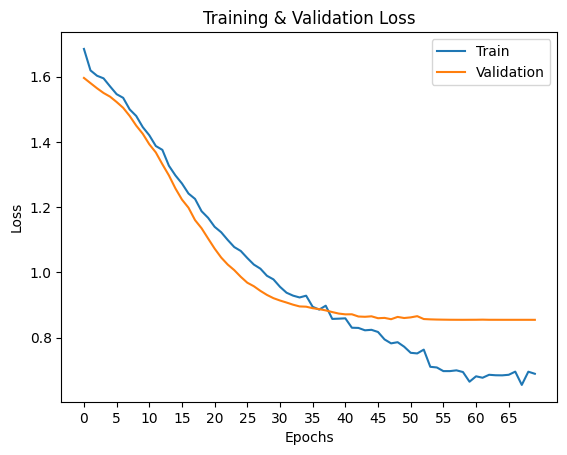

In [15]:
# Loss plot
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Training & Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0, 70, 5))
plt.legend()
plt.show();

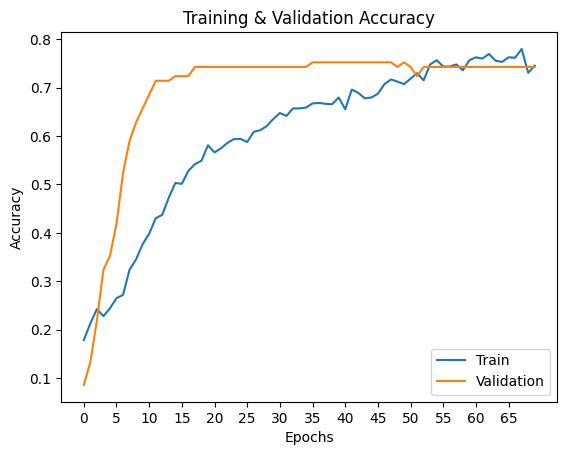

In [16]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Training & Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0, 70, 5))
plt.legend()
plt.show();

In [17]:
print('Training Performance:')
train_results = bert_lstm.evaluate(train_ds)
print('loss', train_results[0])
print('accuracy', train_results[1])
print('recall', train_results[2])
print('precision', train_results[3])

Training Performance:
1155/1155 [==============================] - 32s 24ms/step - loss: 0.5487 - accuracy: 0.8424 - recall: 0.7576 - precision: 0.8984
loss 0.5486735105514526
accuracy 0.842424213886261
recall 0.7575757503509521
precision 0.8983572721481323


In [18]:
print('Testing Performance:')
train_results = bert_lstm.evaluate(test_ds)
print('loss', train_results[0])
print('accuracy', train_results[1])
print('recall', train_results[2])
print('precision', train_results[3])

Testing Performance:
105/105 [==============================] - 2s 23ms/step - loss: 0.8550 - accuracy: 0.7429 - recall: 0.6952 - precision: 0.7684
loss 0.8549782633781433
accuracy 0.7428571581840515
recall 0.6952381134033203
precision 0.7684210538864136


In [22]:
bert_lstm.save(f'{PROJECT_DIR}/models/bert_lstm_copy4/bert_lstm_model.h5')

In [23]:
bert_lstm.save_weights(f'{PROJECT_DIR}/models/bert_lstm_copy4/bert_lstm_model_weights.h5')

In [24]:
bert_lstm.save(f'{PROJECT_DIR}/models/bert_lstm_copy4/bert_lstm_model', save_format='tf')

In [25]:
bert_lstm.save(f'{PROJECT_DIR}/models/bert_lstm_copy4/bert_lstm_model.keras')